# Load Required Modules

In [2]:
# Dataset: https://www.kaggle.com/datasets/sshubam/insat3d-infrared-raw-cyclone-images-20132021

In [5]:
pip install opencv-contrib-python


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import seaborn as sns

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, ReLU

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
import glob
warnings.filterwarnings("ignore")

# MetaData Load

In [31]:
# Load the dataset containing metadata about the cyclone images
# train = pd.read_csv("../input/insat3d-infrared-raw-cyclone-images-20132021/insat_3d_ds - Sheet.csv")

train = pd.read_csv("insat3d/insat_3d_ds - Sheet.csv")


# Image Visualization

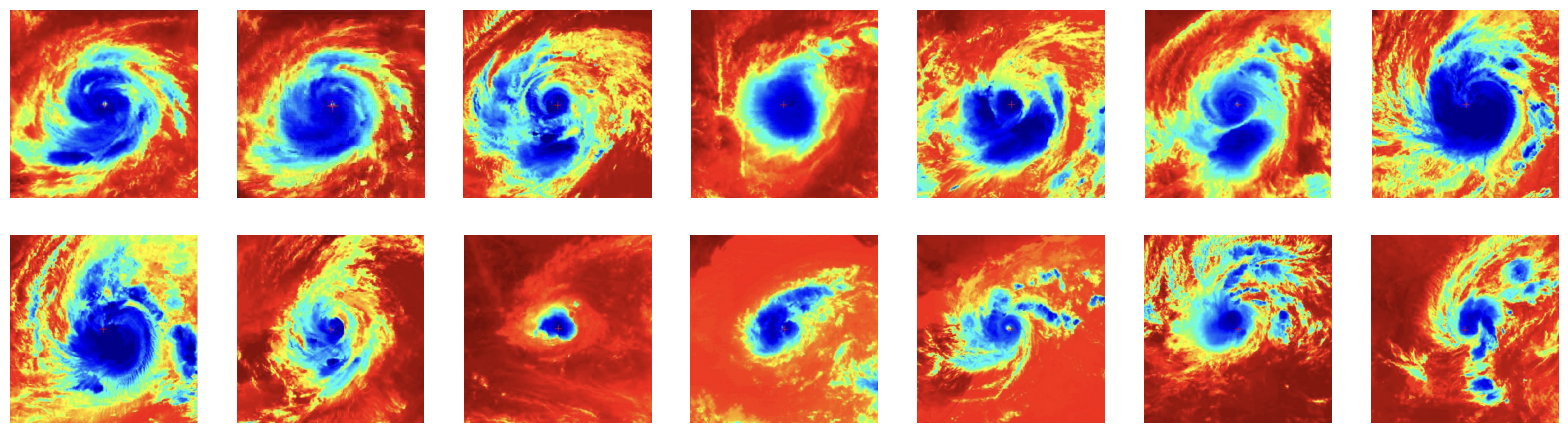

In [34]:
# Visualize infrared cyclone images
paths = glob.glob("insat3d/insat3d_ir_cyclone_ds/CYCLONE_DATASET_INFRARED/*.jpg")
plt.figure(figsize=(20, 20))
for i in range(14):
    cur_img = mpimg.imread(paths[i]) 
    ax = plt.subplot(7, 7, i + 1)
    plt.imshow(cur_img.astype("uint8"))
    plt.axis("off")

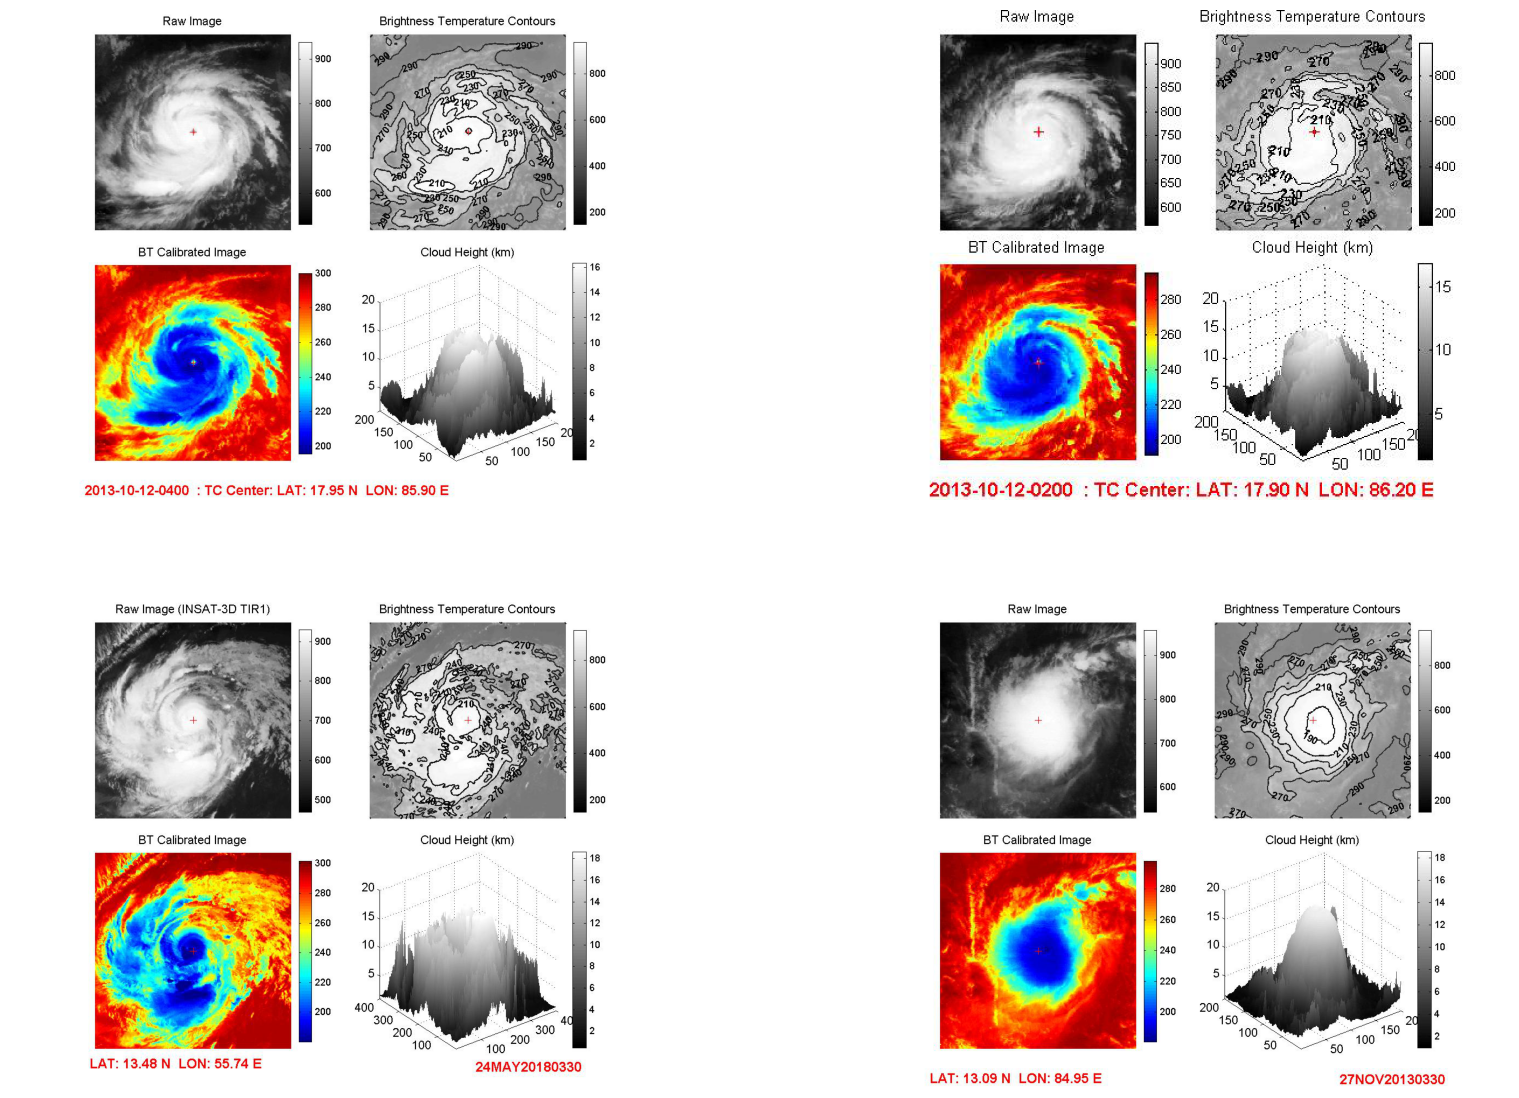

In [36]:
# Visualize reference cyclone images
paths = glob.glob("insat3d/insat3d_for_reference_ds/CYCLONE_DATASET/*.jpeg")
plt.figure(figsize=(20, 14))
for i in range(4):
    cur_img = mpimg.imread(paths[i]) 
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(cur_img.astype("uint8"))
    plt.axis("off")

In [38]:
# Preprocess images and load them into batches
train_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Loading the Train Dataset

In [41]:
train_data = train_datagen.flow_from_dataframe(
    train,
    directory="insat3d/insat3d_ir_cyclone_ds/CYCLONE_DATASET_INFRARED",
    subset="training",
    x_col="img_name",
    y_col="label",
    target_size=(512, 512),
    batch_size=16,
    class_mode='raw'
)

Found 136 validated image filenames.


In [43]:
for image_batch, labels_batch in train_data:
    print(image_batch.shape)
    print(labels_batch.shape)
    break


(16, 512, 512, 3)
(16,)


# Main Model Build

In [46]:
import cv2
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense

# Region Proposal using Selective Search
def extract_regions(image):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()  # Use fast selective search
    rects = ss.process()  # Get region proposals
    return rects[:200]  # Limit to top 200 proposals for efficiency

# RCNN Model
def build_rcnn_model():
    # Define the input
    inputs = Input(shape=(224, 224, 3))  # Resize each ROI to 224x224
    
    # Convolutional base for feature extraction
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Flatten the extracted features
    x = Flatten()(x)

    # Dense layers for classification and regression
    dense1 = Dense(128, activation='relu')(x)
    dense1 = Dense(64, activation='relu')(dense1)
    output = Dense(1, activation='linear')(dense1)  # Predict intensity

    # Create the model
    model = Model(inputs, output)
    return model

# Example: Extract and process regions
def process_image_with_rcnn(image, model):
    regions = extract_regions(image)
    results = []

    for (x, y, w, h) in regions:
        # Extract the ROI
        roi = image[y:y+h, x:x+w]
        roi_resized = cv2.resize(roi, (224, 224))  # Resize to model input size
        
        # Predict with the model
        roi_input = np.expand_dims(roi_resized, axis=0)  # Add batch dimension
        pred = model.predict(roi_input)
        results.append((x, y, w, h, pred[0][0]))  # Append predictions
    
    return results


In [48]:
# Initialize the RCNN model
model = build_rcnn_model()

# Model Compilation

In [51]:
# Compile the RCNN model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='mae', 
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Model Training

In [ ]:
# Train the RCNN model
save_best = ModelCheckpoint("RCNN_Model.h5", monitor='loss', save_best_only=True, verbose=1)
model.fit(train_data, epochs=25, callbacks=[save_best])

In [ ]:
# Evaluate the RCNN model
model = tf.keras.models.load_model('./RCNN_Model.h5')
model.evaluate(train_data)

# Prediction

In [22]:
pip install tensorflow==2.13.0

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


In [54]:
import tensorflow as tf
from tensorflow.keras.layers import SeparableConv2D

# Define the custom layers if needed (like SeparableConv2D)
custom_objects = {
    'SeparableConv2D': SeparableConv2D
}

# Load the model with custom objects
model = tf.keras.models.load_model("Model.h5", custom_objects=custom_objects)

# Evaluate the model
model.evaluate(train_data)


9/9 [==============================] - 31s 3s/step - loss: 2.4393 - root_mean_squared_error: 2.8255


[2.4393177032470703, 2.8254847526550293]

In [56]:
# Predict the cyclone intensity and visualize predictions
pred = model.predict(train_data, verbose=1).round(2)

9/9 [==============================] - 32s 3s/step


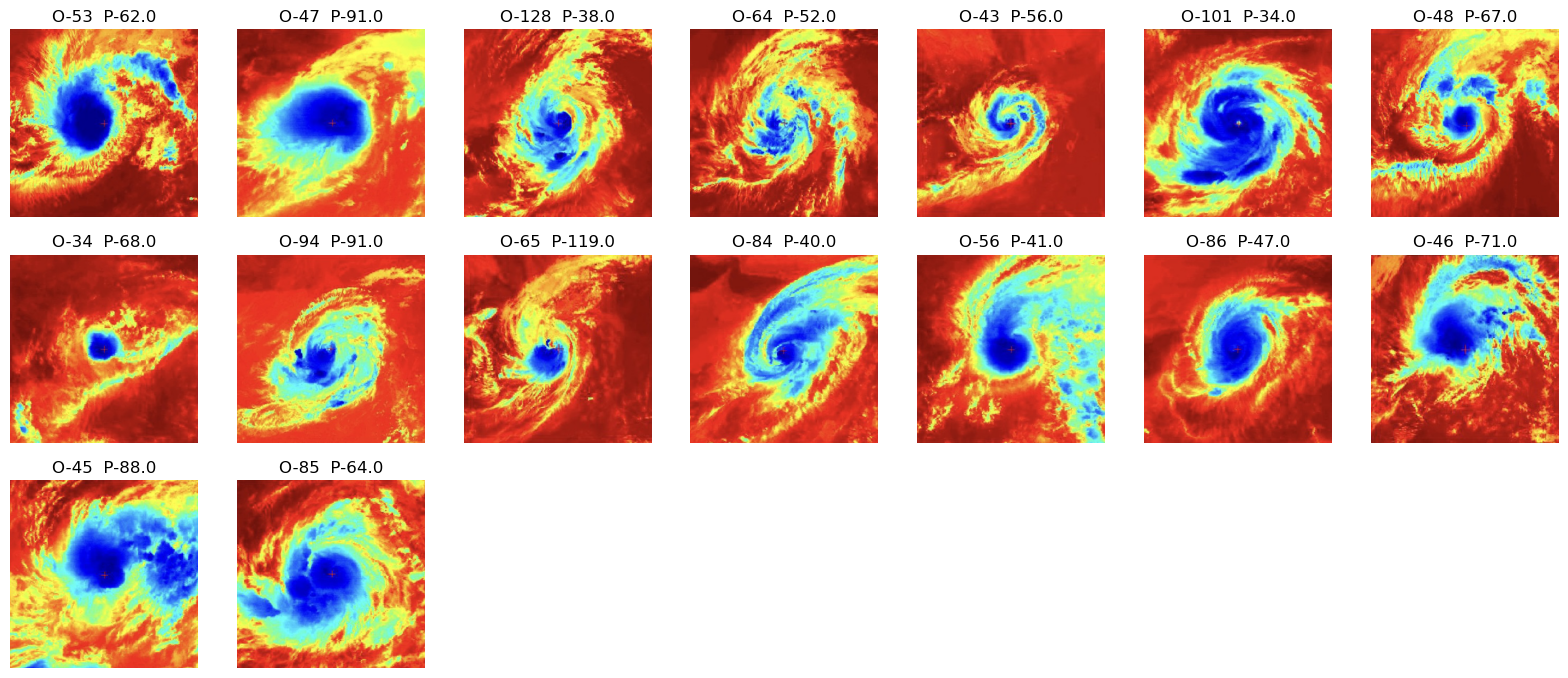

In [57]:
plt.figure(figsize=(20, 20))
for i in range(16):
    cur_img = train_data[0][0][i]
    ax = plt.subplot(7, 7, i + 1)
    plt.title("O-"+str(train_data[0][1][i])+"  P-"+str(pred[i][0].round()))
    plt.imshow(cur_img)
    plt.axis("off")

In [58]:
# Display final predictions as a reshaped array
pred.reshape(-1,)  # Predicted Intensities

array([ 62.22,  90.93,  37.55,  51.5 ,  55.91,  34.04,  66.75,  67.55,
        90.71, 119.26,  40.18,  41.47,  47.11,  70.66,  88.37,  64.42,
        88.58,  65.54,  58.39,  45.18,  48.42,  57.97,  60.54,  35.32,
        51.29,  46.11,  51.08,  79.98,  85.76, 103.83,  60.32,  48.61,
        45.6 ,  89.17,  47.01,  62.28,  63.13,  62.77, 124.08,  58.88,
        49.95,  30.72,  60.11,  55.62,  36.81,  40.89,  74.44,  49.02,
        42.91,  61.39,  87.63,  71.65,  65.41, 111.7 ,  76.82,  99.73,
        39.16,  35.78,  66.73,  46.09,  41.57,  56.91, 104.33,  62.06,
        26.27,  43.73,  71.12,  54.02,  63.13,  32.18,  71.72,  51.14,
        27.63,  35.05,  49.28,  47.96,  54.46,  35.87,  46.17,  78.5 ,
        37.36,  76.96,  50.98,  63.61,  55.35,  96.89,  72.51,  37.35,
        46.87,  47.54,  48.44,  53.63,  83.39,  51.7 ,  54.58,  86.3 ,
        68.82,  63.41, 124.03,  54.84,  44.67,  91.65,  94.98,  36.85,
        46.65,  37.45,  48.97,  75.45,  46.8 ,  88.54,  30.08,  45.44,
      

# Performance Metrics

In [60]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

true_labels = train_data.labels 
pred_labels = pred.reshape(-1)  

# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(true_labels, pred_labels)
print("Mean Absolute Error (MAE):", mae)

# Calculate MSE (Mean Squared Error)
mse = mean_squared_error(true_labels, pred_labels)
print("Mean Squared Error (MSE):", mse)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Visualisation
metrics = ['MAE', 'MSE', 'RMSE']
values = [mae, mse, rmse]

# Create a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['blue', 'green', 'orange'], alpha=0.7)
plt.title("Regression Metrics Comparison", fontsize=16)
plt.ylabel("Value", fontsize=14)
plt.xlabel("Metrics", fontsize=14)

# Annotate the values on the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.3f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


Mean Absolute Error (MAE): 24.339338681277106
Mean Squared Error (MSE): 933.8533425269543
Root Mean Squared Error (RMSE): 30.55901409612153


1/1 [==============================] - 0s 300ms/step


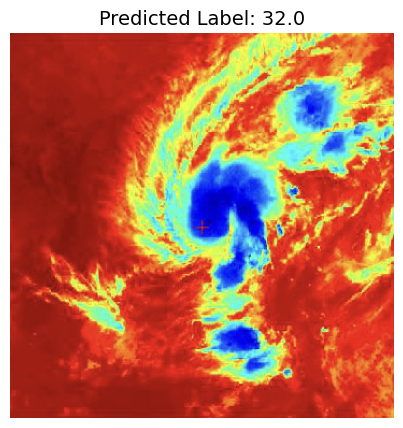

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tkinter import Tk
from tkinter.filedialog import askopenfilename

# Function to upload an image
def upload_image():
    Tk().withdraw()  # Prevents the root window from appearing
    filename = askopenfilename(filetypes=[("Image files", "*.jpg;*.jpeg;*.png")])
    return filename

# Preprocess the image
def preprocess_image(image_path, target_size=(512, 512)):
    img = load_img(image_path, target_size=target_size)  # Load and resize the image
    img_array = img_to_array(img)  # Convert to array
    img_array = img_array / 255.0  # Normalize pixel values
    return np.expand_dims(img_array, axis=0)  # Add batch dimension

# Load the image and predict
image_path = upload_image()  # Open file dialog to select an image
if image_path:
    preprocessed_image = preprocess_image(image_path)

    # Make the prediction
    prediction = model.predict(preprocessed_image)  # Assuming `model` is your trained model
    predicted_label = prediction[0][0].round()  # Round off the prediction for display

    # Display the image with the prediction
    plt.figure(figsize=(5, 5))
    plt.imshow(load_img(image_path))  # Show the original image
    plt.title(f"Predicted Label: {predicted_label}", fontsize=14)
    plt.axis("off")
    plt.show()
else:
    print("No image selected.")
